In [1]:
from math import log, exp
ln = log
import random
from pprint import pprint
import numpy as np
from collections import defaultdict
%matplotlib inline
from matplotlib import pyplot

In [2]:
def random_choice(choices, weights=None):
    """ Select a random element in choices using a as weights. """
    if weights is None:
        weights = [1 for _ in range(len(choices))]
    r2 = random.random()
    breaking_point = r2*sum(weights)
    j = 0
    sum_j = weights[j]
    while sum_j < breaking_point:
        j += 1
        sum_j += weights[j]
    return choices[j]

In [3]:
def minimal_ssa(rate_constants, N_steps_max=100000, time_max=None, start_state=None):
    """ Minimal stochastic simulation algorithm. rate_constants: dict of dicts, [start][end] = k(start->end) """
    time, N_steps, stats = 0, 0, []
    state = start_state if start_state is not None else random.choice(list(rate_constants.keys()))
    while N_steps < N_steps_max and (time_max is None or time < time_max):
        end_states, a = zip(*rate_constants[state].items())
        tau = ln(1/random.random())/sum(a)  # or np.random.exponential(1/sum(a))
        stats.append({'state': state, 'tau': tau, 'time': time})
        state = random_choice(end_states, weights=a)
        time += tau
        N_steps += 1
    return stats

In [4]:
def throttled_ssa(rate_constants, throttle_func=None, N_steps_max=100000, time_max=None, start_state=None):
    """ Minimal stochastic simulation algorithm. rate_constants: dict of dicts, [start][end] = k(start->end) """
    time, N_steps, stats = 0, 0, []
    state_count = {k: 0 for k in rate_constants.keys()}
    reaction_count = {(source, target): 0 
                      for source, targets in rate_constants.items() for target in targets.keys()}
    cycle_count = {k: 0 for k in rate_constants.keys()}

    if throttle_func is None:
        throttle_func = lambda state, end_state, state_counts, cycle_counts, reaction_count: 1
    state = start_state if start_state is not None else random.choice(list(rate_constants.keys()))
    while N_steps < N_steps_max and (time_max is None or time < time_max):
        #end_states, a = zip(*rate_constants[state].items())
        end_states, a = zip(*[(end_state, k*throttle_func(state, end_state, state_count, cycle_count, reaction_count)) 
                              for end_state, k in rate_constants[state].items()])
        tau = ln(1/random.random())/sum(a)  # or np.random.exponential(1/sum(a))
        end_state = random_choice(end_states, weights=a)
        stats.append({'state': state, 'tau': tau, 'time': time})
        state_count[state] += 1
        reaction_count[(state, end_state)] += 1
        state = end_state
        time += tau
        N_steps += 1
    state_times = {state: sum(step['tau'] for step in stats if step['state'] == state)
                   for state in rate_constants.keys()}
    result = dict(zip("stats, cycle_count, state_count, time, state".split(", "),
                      [stats, cycle_count, state_count, time, state]))
    return stats

In [5]:
def decay_throttled_ssa(rate_constants, decay_base=1, N_steps_max=100000, time_max=None, start_state=None):
    """ 
    Decayed throttle as:
        throttle_factor = decay_base ^ N
    decay base is typically 0.9-1.0.
    The expression is equilvalent to the usual exponential throttle: e^(-a*N) = (e^(-a))^N, throttle_factor = decay_base^x
    <=> decay_base = e^(-a), i.e. if a is 0.002, then decay_base = e^(-0.002) = 0.998.
    The only difference is that instead of calculating exp(-a*N) every time, we only calculate
        throttle_factor = throttle_factor * decay_base,
    i.e. we calculate f(N) = f(N-1) * decay_base
    """
    time, N_steps, stats = 0, 0, []
    state_count = {k: 0 for k in rate_constants.keys()}
    reaction_count = {(source, target): 0 
                      for source, targets in rate_constants.items() for target in targets.keys()}
    reaction_throttles = {tup: 1 for tup in reaction_count}

    state = start_state if start_state is not None else random.choice(list(rate_constants.keys()))
    while N_steps < N_steps_max and (time_max is None or time < time_max):
        #end_states, a = zip(*rate_constants[state].items())
        end_states, a = zip(*[(end_state, k*reaction_throttles[(state, end_state)]) 
                              for end_state, k in rate_constants[state].items()])
        tau = ln(1/random.random())/sum(a)  # or np.random.exponential(1/sum(a))
        end_state = random_choice(end_states, weights=a)
        stats.append({'state': state, 'tau': tau, 'time': time})
        state_count[state] += 1
        reaction_count[(state, end_state)] += 1
        reaction_throttles[(state, end_state)] *= decay_base
        state = end_state
        time += tau
        N_steps += 1
    state_times = {state: sum(step['tau'] for step in stats if step['state'] == state)
                   for state in rate_constants.keys()}
    result = dict(zip("stats, state_count, reaction_count, reaction_throttles, time, state".split(", "),
                      [stats, state_count, reaction_count, reaction_throttles, time, state]))
    return stats

In [6]:
def state_times(stats, states):
    return {state: sum(step['tau'] for step in stats if step['state'] == state) for state in states}

def plot_time_partitions(stats, states):
    # state_partitions = state_times(stats, states)
    state_partitions = {state: sum(step['tau'] for step in stats if step['state'] == state) for state in rates.keys()}
    times = [state_partitions[state] for state in states]
    indices = range(len(states))
    barwidth = 0.5
    ax = pyplot.bar(indices, times, width=barwidth, alpha=0.5)
    ticks = pyplot.xticks([i+barwidth/2 for i in indices], states)
    xlims = pyplot.xlim(xmin=-0.1)
    title = pyplot.title('Cumulative state time')


In [7]:
# throttled_ssa(rate_constants, throttle_func=None, N_steps_max=100000, time_max=None, start_state=None)
def simulate_n_times(N_sims, rates, throttle_func=None, N_steps_max=20000, start_state="", decay_base=None):
    K_hybs = []
    all_stats = []
    for i in range(N_sims):
        if throttle_func:
            stats = throttled_ssa(rates, throttle_func=throttle_func, N_steps_max=N_steps_max, start_state=start_state)
        elif decay_base:
            stats = decay_throttled_ssa(rates, decay_base=decay_base, N_steps_max=N_steps_max, start_state=start_state)
        else:
            stats = minimal_ssa(rates, N_steps_max=N_steps_max, start_state=start_state)
        all_stats.append(stats)
        state_tot_times = {state: sum(step['tau'] for step in stats if step['state'] == state) for state in rates.keys()}
        tot_time = sum(state_tot_times.values())
        state_partitions = {state: state_time/tot_time for state, state_time in state_tot_times.items()}
        K_hyb = sum(state_partitions[state] for state in states if state != "")/state_partitions[""]
        K_hybs.append(K_hyb)
        print(".", end="")
    print("")
    return all_stats, state_partitions, K_hybs

In [8]:
### Nearest Neighbor (NN) Energy model  -- in units of R
R = 1.987 # cal/mol/K
DNA_NN3_extra = {
    # Units of kcal/mol and cal/mol/K
    'init': (0, 0), 'init_A/T': (2.3, 4.1), 'init_G/C': (0.1, -2.8),
    'init_oneG/C': (0, 0), 'init_allA/T': (0, 0), 'init_5T/A': (0, 0),
    'sym': (0, -1.4)}
# Convert to units of R and R/K:
DNA_NN3_extra = {stack: (dH*1000/R, dS/R) for stack, (dH, dS) in DNA_NN3_extra.items()}
DNA_NN3_stacks = {
    'AA/TT': (-7.9, -22.2), 'AT/TA': (-7.2, -20.4), 'TA/AT': (-7.2, -21.3),
    'CA/GT': (-8.5, -22.7), 'GT/CA': (-8.4, -22.4), 'CT/GA': (-7.8, -21.0),
    'GA/CT': (-8.2, -22.2), 'CG/GC': (-10.6, -27.2), 'GC/CG': (-9.8, -24.4),
    'GG/CC': (-8.0, -19.9)}
# Convert to units of R and R/K:
DNA_NN3_stacks = {stack: (dH*1000/R, dS/R) for stack, (dH, dS) in DNA_NN3_stacks.items()}
DNA_NN3 = dict(DNA_NN3_extra)
DNA_NN3.update(DNA_NN3_stacks)
avg_stack = (sum(dH for dH, dS in DNA_NN3_stacks.values())/len(DNA_NN3_stacks),
             sum(dS for dH, dS in DNA_NN3_stacks.values())/len(DNA_NN3_stacks))
print("avg_stack dH, dS:", avg_stack)

avg_stack dH, dS: (-4207.347760442879, -11.258178158027174)


Energies, E, relative to spatially confined but un-paired state (at T=330, in units of R*T = 655.71 cal/mol):
{'a': -6.669698355823797, '': -13.30268693153561, 'b': -4.275347194487239, 'abs': -12.48231049975515, 'ab': -10.945045550311036}
Expected state partition functions: z_i = exp(-E/RT)
Rate constants:
   ->  a: 1.6700000000000002
   ->  b: 1.6700000000000002
a  ->   : 1268.7814138146848
a  -> ab: 1000000.0
ab ->  a: 13907.219370726263
ab ->abs: 1000000.0
ab ->  b: 1268.7814138146848
abs-> ab: 214968.24714821109
b  ->   : 13907.219370726263
b  -> ab: 1000000.0

end_time: 0.493
N_stats: 100000
State - simulated vs expected partitions:
   : 0.4322 vs 0.6509
  a: 0.00135 vs 0.0008567
  b: 0.0001636 vs 7.816e-05
 ab: 0.09934 vs 0.0616
abs: 0.467 vs 0.2866

K_on = 0.5678/0.4322 = 1.3139


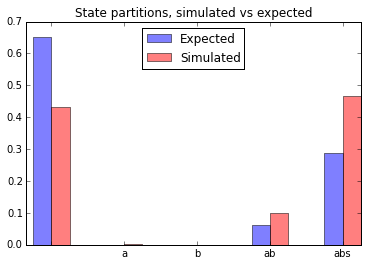

In [9]:
## Self-consistent two-domain binding:
## Emulates the "two-domain duplex hybridization and melting" case.
## Off-rates depends on energy (volume) *difference*, but on-rates does not.
## 
## These are in units of R:
states = ["", "a", "b", "ab", "abs"]
dH_dS = {('b/2', 'B/2'): (-26774.031202818318, -76.858080692841),
         ('B/2', 'b/2'): (-26774.031202818314, -76.858080692841),
         'b': (-26774.031202818318, -76.858080692841),
         'a': (-31051.836940110716, -87.42677722026929),
         ('a/2', 'A/2'): (-31051.836940110716, -87.42677722026929)
        }
T = 330
#dE = {'a': -4, 'b': -3, 's': -0.7} # in units of RT
conc = 1.67e-6
# Energies (at T=T)
dE = {'a': dH_dS['a'][0]/T - dH_dS['a'][1], # dH is in units of R/K, dS is in units of 
      'b': dH_dS['b'][0]/T - dH_dS['b'][1], 
      's': DNA_NN3['GT/CA'][0]/T - DNA_NN3['GT/CA'][1],
    } # in units of RT
E = {'a': dH_dS['a'][0]/T - dH_dS['a'][1], # dH is in units of R/K, dS is in units of 
     'b': dH_dS['b'][0]/T - dH_dS['b'][1], 
     "": R*T*ln(conc)/(R*T)
    } # in units of RT
E['ab'] = E['a'] + E['b']
E['abs'] = E['ab'] + dE['s']
print("Energies, E, relative to spatially confined but un-paired state (at T=%s, in units of R*T = %s cal/mol):" % 
      (T, R*T))
print(E)
print("Expected state partition functions: z_i = exp(-E/RT)")
# we already have energies in units of R*T, so E/RT = E
partitions = {state: exp(-Ei) for state, Ei in E.items()}
Z = sum(partitions.values())
partitions = {state: Ei/Z for state, Ei in partitions.items()}

## Plot theoretical partitions:
partitions_lst = [partitions[state] for state in states]
offset=0
indices = [offset+i for i in range(len(states))]
barwidth = 0.25
ax = pyplot.bar(indices, partitions_lst, width=barwidth, alpha=0.5, label="Expected")
ticks = pyplot.xticks([i+barwidth/2 for i in indices], states)
xlims = pyplot.xlim(xmin=-0.1)
title = pyplot.title('Cumulative state time')


k_on = 1e6
# K = k_on/k_off = exp(-dG/RT), k_off = k_on * exp(dG/RT)
"""
           ,----------.       
     ,--- a ---.       \      
    /           \       \     
  u              ab --- abs   
    \           /       /     
     `--- b ---´       /      
           `----------´       
"""
rates = {
            "": {"a": k_on*conc, "b": k_on*conc},
            "a": {"": k_on*exp(dE['a']), "ab": k_on},
            "b": {"": k_on*exp(dE['b']), "ab": k_on},
            "ab": {"a": k_on*exp(dE['b']), "b": k_on*exp(dE['a']), "abs": k_on},
            "abs": {"ab": k_on*exp(dE['s'])},
            #"abs": {"a": k_on*exp(dE['b']+dE['s']), "b": k_on*exp(dE['a']+dE['s'])},
        }
print("Rate constants:")
print("\n".join("{:<3}->{:>3}: {}".format(source, target, k) for source, targets in sorted(rates.items()) 
                for target, k in sorted(targets.items())))

stats = minimal_ssa(rates, N_steps_max=100000, start_state="")

print("\nend_time: %0.03g" % stats[-1]['time'])
print("N_stats: %s" % len(stats))
#pyplot.figure(figsize=(10, 5))
#plot_time_partitions(stats, states=states)
state_time_total = {state: sum(step['tau'] for step in stats if step['state'] == state) for state in rates.keys()}
#state_time_total = [state_time_total[state] for state in states]
total_sim_time = sum(state_time_total.values())
sim_partitions = {state: state_time/total_sim_time for state, state_time in state_time_total.items()}
sim_partitions_lst = [sim_partitions[state] for state in states]

offset=barwidth
indices = [offset+i for i in range(len(states))]
ax = pyplot.bar(indices, sim_partitions_lst, width=barwidth, alpha=0.5, label="Simulated", color="red")
#ticks = pyplot.xticks([i+barwidth/2 for i in indices], states)
ticks = pyplot.xticks([i for i in indices], states)
xlims = pyplot.xlim(xmin=-0.1)
title = pyplot.title('State partitions, simulated vs expected')
pyplot.legend(loc="upper center")

#df = pd.DataFrame(state_partitions)
print("State - simulated vs expected partitions:")
print("\n".join("{:>3}: {:0.4g} vs {:0.4g}".format(state, sim_partitions[state], partitions[state]) for state in states))
#print(df)
unhybridized = sim_partitions[""]
hybridized = sum(sim_partitions[state] for state in states if state != "")
K_hyb = hybridized/unhybridized
print("\nK_on = %0.04g/%0.04g = %0.4f" % (hybridized, unhybridized, K_hyb))

Thermodynamic/energetic equilibrium constants:
K( ab/   ) = 0.0946
K(abs/   ) = 0.44
..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
..................................................


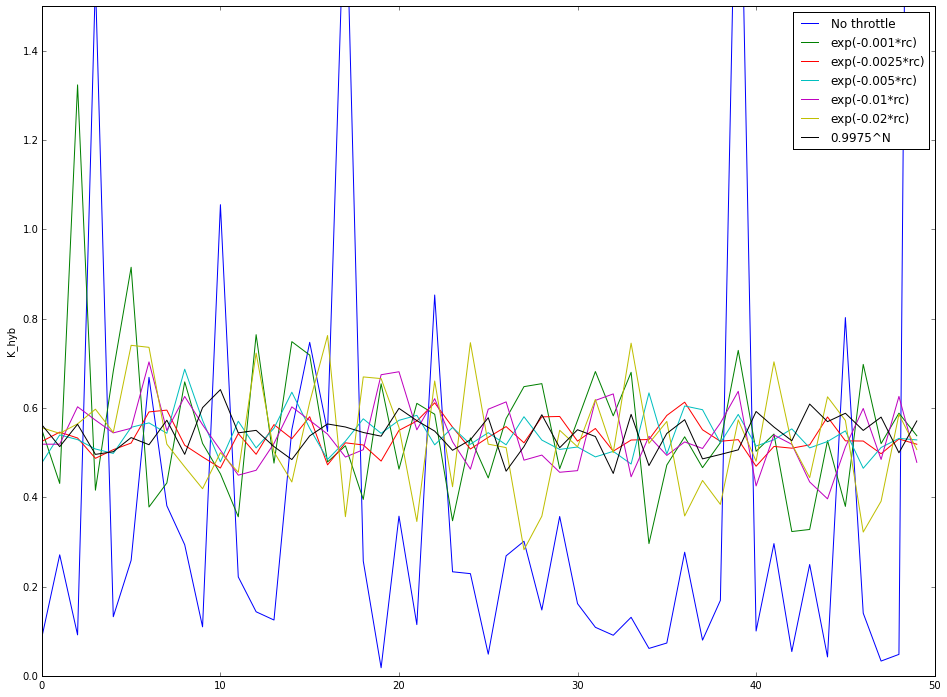

In [35]:
N_sims = 50
N_steps_max = 100000

conc = 1.667e-6

#dE = {'a': -3, 'b': -4, 's': -1.2} # in units of RT
states = ["", "a", "b", "ab", "abs"]
#state_energies = {"": 0, "a": dE['a'], "b": dE['b'], "ab": dE['a']+dE['b'], "abs": dE['a']+dE['b']+dE['s']}
state_energies = E

rates = {
            "": {"a": k_on*conc, "b": k_on*conc},
            "a": {"": k_on*exp(dE['a']), "ab": k_on},
            "b": {"": k_on*exp(dE['b']), "ab": k_on},
            "ab": {"a": k_on*exp(dE['b']), "b": k_on*exp(dE['a']), "abs": k_on},
            "abs": {"ab": k_on*exp(dE['s'])},
            #"abs": {"a": k_on*exp(dE['b']+dE['s']), "b": k_on*exp(dE['a']+dE['s'])},
        }

print("Thermodynamic/energetic equilibrium constants:")
K = {(target, source): exp(state_energies[source]-state_energies[target]) 
     for source, target in (("", "a"), ("", "b"), ("", "ab"), ("", "abs"),
                            ("a", "ab"), ("ab", "abs"), ("a", "abs"))}
print("\n".join("K(%3s/%3s) = %0.03g" % (target, source, exp(state_energies[source]-state_energies[target]))
                for source, target in (("", "ab"), ("", "abs"))))

pyplot.figure(figsize=(16, 12))

## No throttle:
all_stats, state_partitions, Ks = simulate_n_times(N_sims, rates, throttle_func=None)
pyplot.plot(Ks, label="No throttle")


## Exponential:
def throttle_func(state, end_state, state_counts, cycle_counts, reaction_count): 
    return exp(-0.001*reaction_count[(state, end_state)])
all_stats, state_partitions, Ks = simulate_n_times(N_sims, rates, throttle_func=throttle_func)
pyplot.plot(Ks, label="exp(-0.001*rc)")

## Exponential:
def throttle_func(state, end_state, state_counts, cycle_counts, reaction_count): 
    return exp(-0.003*reaction_count[(state, end_state)])
all_stats, state_partitions, Ks = simulate_n_times(N_sims, rates, throttle_func=throttle_func)
pyplot.plot(Ks, label="exp(-0.0025*rc)")

## Exponential:
def throttle_func(state, end_state, state_counts, cycle_counts, reaction_count): 
    return exp(-0.003*reaction_count[(state, end_state)])
all_stats, state_partitions, Ks = simulate_n_times(N_sims, rates, throttle_func=throttle_func)
pyplot.plot(Ks, label="exp(-0.005*rc)")

## Exponential:
def throttle_func(state, end_state, state_counts, cycle_counts, reaction_count): 
    return exp(-0.01*reaction_count[(state, end_state)])
all_stats, state_partitions, Ks = simulate_n_times(N_sims, rates, throttle_func=throttle_func)
pyplot.plot(Ks, label="exp(-0.01*rc)")

## Exponential:
def throttle_func(state, end_state, state_counts, cycle_counts, reaction_count): 
    return exp(-0.03*reaction_count[(state, end_state)])
all_stats, state_partitions, Ks = simulate_n_times(N_sims, rates, throttle_func=throttle_func)
pyplot.plot(Ks, label="exp(-0.02*rc)")

## Exponential, decay-throttled, with decay_base equivalent to exp(-0.0025^N)  - decay_base = exp(-a), a = -ln(decay_base)
all_stats, state_partitions, Ks = simulate_n_times(N_sims, rates, decay_base=0.9975)
pyplot.plot(Ks, label="0.9975^N")



## Finishing touch: 
#pyplot.ylim(ymin=0, ymax=1.3*max((max(K_abs_a), max(K_abs_a2), max(K_abs_a3))))
#ymin, ymax = pyplot.ylim()
#if ymax > 1.5:
#    ymax = 1.5
pyplot.ylim((0, 1.5))
pyplot.ylabel("K_hyb")
pyplot.legend()
#print("abs -> ab: avg=%.03f, std=%.03f" % (np.average(Ks), np.std(Ks)))


In [71]:
import math
def hybridization_dH_dS(seq, check=True, c_seq=None, shift=0, nn_table="DNA_NN4",
                        tmm_table="DNA_TMM1", imm_table="DNA_IMM1", de_table="DNA_DE1",
                        selfcomp=False, Na=50, K=0, Tris=0, Mg=0, dNTPs=0, saltcorr=5,
                        verbose=False):

    nn_table = DNA_NN3
    # Combined table:
    comb_table = nn_table.copy()
    # Add the "reversed" neighbourgh pair:
    comb_table.update({k[::-1]: v for k, v in comb_table.items()})

    WC = dict(zip("ATGC", "TACG"))
    c_seq = "".join(WC[b] for b in seq)   # not reversed complement, but the complement from 3' to 5'
    
    tmpseq = seq
    tmp_cseq = c_seq
    deltaH = 0
    deltaS = 0
    dH = 0  # Names for indexes
    dS = 1  # 0 and 1

    # Type: General initiation value
    deltaH += nn_table['init'][dH]
    deltaS += nn_table['init'][dS]

    # Type: Duplex with no (allA/T) or at least one (oneG/C) GC pair
    if seq.count("C") + seq.count("C") == 0:
        deltaH += nn_table['init_allA/T'][dH]
        deltaS += nn_table['init_allA/T'][dS]
    else:
        deltaH += nn_table['init_oneG/C'][dH]
        deltaS += nn_table['init_oneG/C'][dS]

    # Type: Penalty if 5' end is T (for both strands)
    if seq.startswith('T'):
        deltaH += nn_table['init_5T/A'][dH]
        deltaS += nn_table['init_5T/A'][dS]
    if seq.endswith('A'):
        deltaH += nn_table['init_5T/A'][dH]
        deltaS += nn_table['init_5T/A'][dS]

    # Type: Different values for G/C or A/T terminal basepairs
    ends = seq[0] + seq[-1]
    AT = ends.count('A') + ends.count('T')
    GC = ends.count('G') + ends.count('C')
    deltaH += nn_table['init_A/T'][dH] * AT
    deltaS += nn_table['init_A/T'][dS] * AT
    deltaH += nn_table['init_G/C'][dH] * GC
    deltaS += nn_table['init_G/C'][dS] * GC

    # Finally, the 'zipping'
    for basenumber in range(len(tmpseq) - 1):
        neighbors = tmpseq[basenumber:basenumber + 2] + '/' + \
            tmp_cseq[basenumber:basenumber + 2]
        try:
           deltaH += comb_table[neighbors][dH]
           deltaS += comb_table[neighbors][dS]
        except KeyError as e:
           print("Key not found: ", e)
           print("comb_table keys: ", ", ".join(comb_table.keys()))
           raise e
#         if neighbors in imm_table:
#             deltaH += imm_table[neighbors][dH]
#             deltaS += imm_table[neighbors][dS]
#         elif neighbors[::-1] in imm_table:
#             deltaH += imm_table[neighbors[::-1]][dH]
#             deltaS += imm_table[neighbors[::-1]][dS]
#         elif neighbors in nn_table:
#             deltaH += nn_table[neighbors][dH]
#             deltaS += nn_table[neighbors][dS]
#         elif neighbors[::-1] in nn_table:
#             deltaH += nn_table[neighbors[::-1]][dH]
#             deltaS += nn_table[neighbors[::-1]][dS]
#         else:
#             raise KeyError("Could not find key %s when zipping" % neighbors)

    if saltcorr and saltcorr == 5:
        # Only salt correction method #5 considers energy, the others applies to Tm.
        corr = salt_correction(Na=Na, K=K, Tris=Tris, Mg=Mg, dNTPs=dNTPs,
                               method=saltcorr, seq=seq)
        deltaS += corr
    return deltaH, deltaS


def salt_correction(Na=0, K=0, Tris=0, Mg=0, dNTPs=0, method=1, seq=None):
    """Calculate a term to correct Tm for salt ions.

    Depending on the Tm calculation, the term will correct Tm or entropy. To
    calculate corrected Tm values, different operations need to be applied:

     - methods 1-4: Tm(new) = Tm(old) + corr
     - method 5: deltaH(new) = deltaH(old) + corr
     - methods 6+7: Tm(new) = 1/(1/Tm(old) + corr)

    Parameters:
     - Na, K, Tris, Mg, dNTPS: Millimolar concentration of respective ion. To have
       a simple 'salt correction', just pass Na. If any of K, Tris, Mg and
       dNTPS is non-zero, a 'sodium-equivalent' concentration is calculated
       according to von Ahsen et al. (2001, Clin Chem 47: 1956-1961):
       [Na_eq] = [Na+] + [K+] + [Tris]/2 + 120*([Mg2+] - [dNTPs])^0.5
       If [dNTPs] >= [Mg2+]: [Na_eq] = [Na+] + [K+] + [Tris]/2
     - method: Which method to be applied. Methods 1-4 correct Tm, method 5
       corrects deltaS, methods 6 and 7 correct 1/Tm. The methods are:

       1. 16.6 x log[Na+]
          (Schildkraut & Lifson (1965), Biopolymers 3: 195-208)
       2. 16.6 x log([Na+]/(1.0 + 0.7*[Na+]))
          (Wetmur (1991), Crit Rev Biochem Mol Biol 126: 227-259)
       3. 12.5 x log(Na+]
          (SantaLucia et al. (1996), Biochemistry 35: 3555-3562
       4. 11.7 x log[Na+]
          (SantaLucia (1998), Proc Natl Acad Sci USA 95: 1460-1465
       5. Correction for deltaS: 0.368 x (N-1) x ln[Na+]
          (SantaLucia (1998), Proc Natl Acad Sci USA 95: 1460-1465)
       6. (4.29(%GC)-3.95)x1e-5 x ln[Na+] + 9.40e-6 x ln[Na+]^2
          (Owczarzy et al. (2004), Biochemistry 43: 3537-3554)
       7. Complex formula with decision tree and 7 empirical constants.
          Mg2+ is corrected for dNTPs binding (if present)
          (Owczarzy et al. (2008), Biochemistry 47: 5336-5353)

    Examples:

        >>> from Bio.SeqUtils import MeltingTemp as mt
        >>> print('%0.2f' % mt.salt_correction(Na=50, method=1))
        -21.60
        >>> print('%0.2f' % mt.salt_correction(Na=50, method=2))
        -21.85
        >>> print('%0.2f' % mt.salt_correction(Na=100, Tris=20, method=2))
        -16.45
        >>> print('%0.2f' % mt.salt_correction(Na=100, Tris=20, Mg=1.5,
        ...                                    method=2))
        -10.99

    """
    if method in (5, 6, 7) and not seq:
        raise ValueError('sequence is missing (is needed to calculate ' +
                         'GC content or sequence length).')
    if seq:
        seq = str(seq)
    corr = 0
    if not method:
        return corr
    Mon = Na + K + Tris / 2.0  # Note: all these values are millimolar
    mg = Mg * 1e-3             # Lowercase ions (mg, mon, dntps) are molar
    # Na equivalent according to von Ahsen et al. (2001):
    if sum((K, Mg, Tris, dNTPs)) > 0 and not method == 7:
        if dNTPs < Mg:
            # dNTPs bind Mg2+ strongly. If [dNTPs] is larger or equal than
            # [Mg2+], free Mg2+ is considered not to be relevant.
            Mon += 120 * math.sqrt(Mg - dNTPs)
    mon = Mon * 1e-3
    # Note: math.log = ln(), math.log10 = log()
    if method in range(1, 7) and not mon:
        raise ValueError('Total ion concentration of zero is not allowed in ' +
                         'this method.')
    if method == 1:
        corr = 16.6 * math.log10(mon)
    if method == 2:
        corr = 16.6 * math.log10((mon) / (1.0 + 0.7 * (mon)))
    if method == 3:
        corr = 12.5 * math.log10(mon)
    if method == 4:
        corr = 11.7 * math.log10(mon)
    if method == 5:
        corr = 0.368 * (len(seq) - 1) * math.log(mon)
    if method == 6:
        corr = (4.29 * gc_percent(seq) / 100 - 3.95) * 1e-5 * math.log(mon) + \
            9.40e-6 * math.log(mon) ** 2
    if method == 7:
        a, b, c, d = 3.92, -0.911, 6.26, 1.42
        e, f, g = -48.2, 52.5, 8.31
        if dNTPs > 0:
            dntps = dNTPs * 1e-3
            ka = 3e4  # Dissociation constant for Mg:dNTP
            # Free Mg2+ calculation:
            mg = (-(ka * dntps - ka * mg + 1.0) +
                  math.sqrt((ka * dntps - ka * mg + 1.0) ** 2 + 4.0 * ka * mg)) / (2.0 * ka)
        if Mon > 0:
            R = math.sqrt(mg) / mon
            if R < 0.22:
                corr = (4.29 * gc_percent(seq) / 100 - 3.95) * \
                    1e-5 * math.log(mon) + 9.40e-6 * math.log(mon) ** 2
                return corr
            elif R < 6.0:
                a = 3.92 * (0.843 - 0.352 * math.sqrt(mon) * math.log(mon))
                d = 1.42 * (1.279 - 4.03e-3 * math.log(mon) -
                            8.03e-3 * math.log(mon) ** 2)
                g = 8.31 * (0.486 - 0.258 * math.log(mon) +
                            5.25e-3 * math.log(mon) ** 3)
        corr = (a + b * math.log(mg) + (gc_percent(seq) / 100) *
                (c + d * math.log(mg)) + (1 / (2.0 * (len(seq) - 1))) *
                (e + f * math.log(mg) + g * math.log(mg) ** 2)) * 1e-5
    if method > 7:
        raise ValueError('Allowed values for parameter \'method\' are 1-7.')
    return corr


dH, dS = hybridization_dH_dS(seq="GTACCGATGGCATTA")
T = 330
dG_std = dH - T*dS
K = exp(dH/T - dS)
# Q = [duplex]/([strandA] [strandB])
# K = exp(-ΔG°/RT) = exp(ΔS°/R - ΔH°/RT)
print("dH, dS, dG, K: %0.02f R, %0.02f R/K, %0.02f R, %0.02g" % (dH, dS, dG, K))

## Acount for (initial) concentrations:
conc = 1e-6  # strandA
conc2 = conc # concentration of the "other" strand 
if conc < conc2:
    conc, conc2 = conc2, conc

## We can use K directly to calculate equilibrium concentrations, since K is always the same:
# K_melt = [strandA][strandB]/[duplex]
# AT T=Tm: K_melt = conc - conc2/2   # initial concentrations
# Generally: Solve 2nd-order equation...


## We can calculate Tm:
# ΔG = ΔG° + RT ln(Q) = 0 <=> ΔH° - T*ΔS° = ΔG° = -RT ln(Q)  <=> T = ΔH° / (ΔS° - R ln(K))
# Biopython defines the "melting equilibrium constant" K_melt = 1/K_hyb = [strandA][strandB]/[duplex]
# At T=Tm: K = [strandB]*[strandA]/[duplex] = [strandB] # since [duplex] = [strandA]
#            = [strandB]_init - [duplex]                # since [strandB] = [strandB]_init - [duplex]
#            = [strandB]_init - [strandA]_init/2        # since [duplex] = [strandA]_init/2
#            = dnac1 - dnac2 / 2
# k = (dnac1 - (dnac2 / 2.0)) * molar_unit # K_melt
# If dH and dS are in units of kJ/mol and J/mol/K:
# Tm = (1000 * deltaH) / (deltaS + (R * (math.log(k)))) - 273.15   # in Celcius
# Or if we have dH and dS in units of R and R/K:
Tm = dH / (dS + (R * (math.log(k))))   # k = K_melt = 1/K_hyb; ln(K_hyb) = -ln(K_melt)


# Partition functions:
# From statistical mechanics:
#     Z   = sum(exp(-E_s / kT) for s in microstates)   # Partition function for classical canonical ensemble
#     p_s = exp(-E_s / kT) / Z                         # Probability of system being in microstate s

# If we set E_melt = 0 and only consider two states, hybridized an non-hybridized:
# p_h = exp(-E_hyb / kT) / (exp(-E_hyb / kT) + 1)

# But in general, we consider partition of all states:
# Use ΔG° = ΔG° + RT ln(Q) = (ΔH° - TΔS°) + RT ln(Q)   for bi-molecular reactions ()
# Edit: E = 0 is for the melted state but with the two strands confined to the same volume-space as the duplex;
# Thus, E_melted = -RT ln(Q) !
# And for all duplexes: E_duplex_i = ΔG° = ΔH° - TΔS°

# Note that this is only for direct/manual calculation of partition functions;
# when using the SSA, we set E_melted = 0 and just adjust k_on by conc.






dH, dS, dG, K: -56718.67 R, -170.49 R/K, -456.35 R, 0.25


In [262]:
stacks = sorted(DNA_NN3_stacks.keys())
#print(", ".join(DNA_NN3_stacks.keys()))
print(", ".join(stacks))
pprint(DNA_NN3_extra)

AA/TT, AT/TA, CA/GT, CG/GC, CT/GA, GA/CT, GC/CG, GG/CC, GT/CA, TA/AT
{'init': (0.0, 0.0),
 'init_5T/A': (0.0, 0.0),
 'init_A/T': (1157.5239053850025, 2.0634121791645694),
 'init_G/C': (50.327126321087064, -1.4091595369904377),
 'init_allA/T': (0.0, 0.0),
 'init_oneG/C': (0.0, 0.0),
 'sym': (0.0, -0.7045797684952189)}


In [290]:
## New setup, with different duplexes, but using constant reaction throttle method (decay based)
from itertools import product, combinations
from pprint import pprint
from collections import defaultdict

slen = 16 # 32
conc = 1.67e-6

# Tm is about 370 K for GG/CC stack and 350 K for GT/CA and 325 K for AA/TT.
# TMs at c=1.67e-6 M for a 16-mer (excluding self-symmetry):
# Also depends on init_dG!
Tm_by_stack = defaultdict(dict)
Tm_by_stack[16][1.67e-6] = {
    "AA/TT": 329.5, # 0
    "AT/TA": 324.9, # 1
    "CA/GT": 347.5, # 2 
    "CG/GC": 366.0, # 3
    "CT/GA": 342.7, # 4
    "GA/CT": 342.2, # 5
    "GC/CG": 374.6, # 6
    "GG/CC": 369.3, # 7
    "GT/CA": 347.7, # 8
    "TA/AT": 312.2, # 9
    }
Tm_by_stack[32][1.67e-6] = {
    "AA/TT": 342.7, # 0
    "AT/TA": 338.5, # 1
    "CA/GT": 360.9, # 2 
    "CG/GC": 377.8, # 3
    "CT/GA": 356.9, # 4
    "GA/CT": 355.7, # 5
    "GC/CG": 388.1, # 6
    "GG/CC": 385.5, # 7
    "GT/CA": 361.25,# 8
    "TA/AT": 323.0, # 9
    }
print(conc in Tm_by_stack[slen])
#            0      1      2      3      4      5      6      7      8      9
#stacks = "AA/TT, AT/TA, CA/GT, CG/GC, CT/GA, GA/CT, GC/CG, GG/CC, GT/CA, TA/AT".split(", ")
print(", ".join(sorted(Tm_by_stack[slen][conc].keys(), reverse=True, key=lambda k: Tm_by_stack[slen][conc][k])))
stack = stacks[9]
# T = 369
T = Tm_by_stack[slen][conc][stack]
seq = "G"*slen

# Units of R and R/K:
avg_stack_exact = avg_stack
#avg_stack = tuple(map(int, avg_stack))
#avg_stack = avg_stack_exact
avg_stack_dG = sum(dH - T*dS for dH, dS in [avg_stack])
stack_dG = avg_stack_dG
# Keyed as "GT/CA" for stacking between GC base-pair and TA: 5'-GT-3' / 3'-CA-5'
stack_dG = sum(dH - T*dS for dH, dS in (DNA_NN3_stacks["GG/CC"],))
stack_dG = sum(dH - T*dS for dH, dS in (DNA_NN3_stacks["GT/CA"],))
stack_dG = sum(dH - T*dS for dH, dS in (DNA_NN3_stacks[stack],))

init_key = "init_G/C" # 'init', 'init_A/T', 'init_G/C'
init_key = "init_A/T"
init_dG = sum(dH - T*dS for dH, dS in [DNA_NN3_extra[init_key]])/2

RR = 1 # R in units of R (for annotation purposes - RR*T 
#stack_dG = sum(dH - T*dS for dH, dS in (DNA_NN3_stacks["AA/TT"],))
print("stack_dG (%s): %0.02f (in units of R = %s cal/mol)" % (stack, stack_dG, R))
print("init_dG (%s): %0.02f (in units of R = %s cal/mol)" % (init_key, init_dG, R))

actual_domains = "abcdefghijklmopq"

import re
loop_re = "[a-p]([-u:s]+)(?=[a-p])"

#for n_doms in [1, 2, 4]: #, 8]:
for n_doms in [1, 2, 4, 8]:
    print("\n%s divided in %s domains" % (seq, n_doms))
    # print("\n".join("".join(tup) for tup in itertools.product("u"*4, "abcd")))
    dlen = slen/n_doms
    states = ["-".join(tup) for tup in product(*zip("u"*(n_doms), "abcdefghijklmopq"[:n_doms]))]
    unhyb_state = next(state for state in states if all(dom in " u-" for dom in state))
    stacked_states = []
    print("unstacked states:", len(states))
    for state in states:
        # Or use a regex...
        stackable_idxs = [idx for idx, dom in enumerate(state[:-1])
                          if dom == "-" 
                          and state[idx-1] in actual_domains 
                          and state[idx+1] in actual_domains]
        for r in range(1, len(stackable_idxs)+1):
            for idxs in combinations(stackable_idxs, r):
                slices = [slice(idx1 if idx1 is None else idx1+1, idx2) 
                          for idx1, idx2 in zip((None,)+idxs, idxs+(None,))]
                stacked_states.append(":".join(state[slice] for slice in slices))
    print("stacked_states:", len(stacked_states))
    #pprint(stacked_states)
    states += stacked_states
    print("all states:", len(states))
#     E = {state: tuple(map(sum, zip(*[avg_stack if dom in ":s" else [v*dlen for v in avg_stack] 
#                                      for dom in state if dom not in " -u"]))) 
#          for state in states}
    # dlen is domain length, 
    E = {state: sum(stack_dG if dom in ":s" else (stack_dG*(dlen-1) + init_dG)
                    for dom in state if dom not in " -u")
                + sum(
                      #0
                      #R*T*ln(1.0*len(loop))
                      #R*T*ln(0.9*len(loop))
                      R*T*ln(0.8*len(loop))
                      #R*T*ln(1.20*len(loop))
                      #RR*T*ln(4*(len(loop)-0.63)) 
                      for loop in re.findall(loop_re, state))
         for state in states}
    # dG = dG_std + RT ln(Q)
    # E_loop = R*T*ln(1.47*len(loop))      - or R*T*ln(1.41*len(loop))      (for increasing p_hyb with increasing Ndiv)
    # E_loop = R*T*ln(2*(len(loop)-0.25))  - or R*T*ln(2*(len(loop)-0.30))  
    # E_loop = R*T*ln(3*(len(loop)-0.5))   - or R*T*ln(3*(len(loop)-0.53))
    # E_loop = R*T*ln(4*(len(loop)-0.63)   - or R*T*ln(4*(len(loop)-0.65)
    # E_loop = R*T*ln(a*(len(loop)-b))  
    # For len(loop)=1 we want ln(...) > 0  ==> 0 < b < 1 - 1/a
    # Although typically the effective volume does not increase linearly with the loop..
    E[unhyb_state] = T * ln(conc)
    #pprint(E)
    partition_functions = {state: exp(-dG/T) for state, dG in E.items()}
    Z = sum(partition_functions.values())
    partition_functions = {state: p/Z for state, p in partition_functions.items()}
    print("Unhyb partition function: %0.04f (%s)" % (partition_functions[unhyb_state], unhyb_state))
    print("Hybri partition function: %0.04f (all except %s)" % (1-partition_functions[unhyb_state], unhyb_state))
    
    
    



## Exponential, decay-throttled, with decay_base equivalent to exp(-0.0025^N)  - decay_base = exp(-a), a = -ln(decay_base)
#all_stats, Ks = simulate_n_times(N_sims, rates, decay_base=0.9975)
#pyplot.plot(Ks, label="0.9975^N")

#print("Ks avg (std) = %0.03f  (%0.03g)" % (np.average(Ks), np.std(Ks)))


True
GC/CG, GG/CC, CG/GC, GT/CA, CA/GT, CT/GA, GA/CT, AA/TT, AT/TA, TA/AT
stack_dG (TA/AT): -276.87 (in units of R = 1.987 cal/mol)
init_dG (init_A/T): 256.66 (in units of R = 1.987 cal/mol)

GGGGGGGGGGGGGGGG divided in 1 domains
unstacked states: 2
stacked_states: 0
all states: 2
Unhyb partition function: 0.6947 (u)
Hybri partition function: 0.3053 (all except u)

GGGGGGGGGGGGGGGG divided in 2 domains
unstacked states: 4
stacked_states: 1
all states: 5
Unhyb partition function: 0.7015 (u-u)
Hybri partition function: 0.2985 (all except u-u)

GGGGGGGGGGGGGGGG divided in 4 domains
unstacked states: 16
stacked_states: 18
all states: 34
Unhyb partition function: 0.7029 (u-u-u-u)
Hybri partition function: 0.2971 (all except u-u-u-u)

GGGGGGGGGGGGGGGG divided in 8 domains
unstacked states: 256
stacked_states: 1341
all states: 1597
Unhyb partition function: 0.6545 (u-u-u-u-u-u-u-u)
Hybri partition function: 0.3455 (all except u-u-u-u-u-u-u-u)


In [30]:

print(avg_stack)
pprint(DNA_NN3_stacks)

(-4207.347760442879, -11.258178158027174)
{'AA/TT': (-3975.842979365878, -11.172622043281327),
 'AT/TA': (-3623.5530951182686, -10.26673376950176),
 'CA/GT': (-4277.8057372924, -11.424257674886762),
 'CG/GC': (-5334.675390035229, -13.688978359335682),
 'CT/GA': (-3925.515853044791, -10.568696527428283),
 'GA/CT': (-4126.82435832914, -11.172622043281327),
 'GC/CG': (-4932.058379466533, -12.279818822345243),
 'GG/CC': (-4026.170105686965, -10.015098137896326),
 'GT/CA': (-4227.478610971313, -11.273276295923502),
 'TA/AT': (-3623.5530951182686, -10.719677906391546)}


"""
Let's say we want to keep the partition constant as we split a duplex into multiple domains.

If we split a domain in two, we increase the number of states from 1 to 2.
That by it self is an entropy of dS = R ln 2.
Although I guess that is using Stirling's formula, and we probably have to calculate all permutations

Anyway, without using factorials but just with Stirling, we have:
    dS = R ln 2,
For just splitting one domain into two with approximately the same energy levels (stacked and un-stacked...)
Plus, we also have two different states where just one of the two domains are hybridized...
So, in total:
    p_hyb = [2h+s + 2h + 2*1h]
And p_unh = [0h] is constant,
So we go from:
    p_hyb = [1h] / [1h + 0h]
    p_unh = [0h] / [1h + 0h]
to:
    p_hyb = [2h+s + 2h + 2*1h] / [2h+s + 2h + 2*1h + 0h]
    p_unh = [0h] / [2h+s + 2h + 2*1h + 0h]

And we want to keep z_hyb and z_unh relatively constant.
The easiest representation is 1/z_unh = const:
    [2h+s + 2h + 2*1h + 0h]_2 / [0h]_2 = [1h + 0h]_1 / [0h]_1
<==> 1/[0h]_2 * [2h+s + 2h + 2*1h]_2 + 1 = 1/[0h]_1 * [1h]_1 + 1 = const
Since [0h] is constant:
    [2h+s + 2h + 2*1h]_2 = [1h]_1
Or, written in full, with 
    For s/1: E[1h]   = 15*Es      + E0
    For s/2: E[2h+s] = (2*7+1)*Es + E0, 
             E[2h]   = 2*7*Es     + E0, 
             E[1h]   = 7*Es       + E0

Partition for state i: p_i = exp(-Ei/RT)
    p[1h]_1 =   exp(-(15*Es-E0)/RT) = exp(-15*Es/RT) * exp(-E0/RT)
    p[2h+s]_2 = exp(-(2*7+1)Es/RT)*exp(-E0/RT)
    p[2h]_2 =   exp(-2*7*Es/RT)*exp(-E0/RT)
    p[1h]_2 =   exp(-7*Es/RT)*exp(-E0/RT)

Constant "hybridization" partition for s/1 and s/2 (strand divided into 1 or two domains):
    p[1h]_1                      = p[2h+s]_2 + p[2h]_2 + p[1h]_2
    exp(-15*Es/RT) * exp(-E0/RT) = exp(-(2*7+1)Es/RT)*exp(-E0/RT) + exp(-2*7*Es/RT)*exp(-E0/RT) + exp(-7*Es/RT)*exp(-E0/RT)
                                 = [exp(-(2*7+1)Es/RT) + exp(-2*7*Es/RT) + exp(-7*Es/RT) ] * exp(-E0/RT)

As expected, adding a constant offset, E0, to each state doesn't make a difference.
It seems we have to add a factor that is a function of the number of stacks or BPs?


Accounting for multiple (degenerate and non-degenerate) states is mostly entropic.
At T=0, only the minimal-energy state is occupied. 
At T=inf, all states are equally occupied, meaning only the ensemble entropy matters.

What about adding an "activity factor" that is just < 1?
* Is this a loop energy?
* It is constant.
* But, it doesn't apply to s/1:[1h], or s/2:[1h],
* It only applies to s/2:[2h] and s/2:[2h+s]

* An activity factor of 0.5 is equivalent to dS_hyb = R ln(2) and dE_loop = RT ln(2):
* Only affects on rate: k'on = 0.5 k_on,   k'off = k_off
* K' = k'on/k'off = 0.5 k_on/k_off = 0.5 * K
* K = exp(-dG/RT),
* K' = exp(-dG'/RT) = 0.5 K = 0.5 exp(-dG/RT) = exp(ln(0.5)) exp(-dG/RT) = exp(-ln(2)-dG/RT)
* dG' = dG + RT ln(2) = dG - RT ln(0.5)

What is the total loop energy?
* a-b-c-d-e-f-g-h    - 8 loops á RT ln(2)
* a-b-c-u-e-f-g-h    - 5 loops á RT ln(2) + 1 loop á RT ln(2+dlen)

Fitting a and b in 
    E_loop = R*T*ln(a*(len(loop)-b))  
so that p_unhyb remains constant (or slightly increasing) with increasing Ndoms from 1...8.
Note that for len(loop)=1 we want ln(...) > 0  ==> 0 < b < 1 - 1/a
These work well:
    E_loop = R*T*ln(1.47*len(loop))      - or R*T*ln(1.41*len(loop))      (for increasing p_hyb with increasing Ndiv)
    E_loop = R*T*ln(2*(len(loop)-0.25))  - or R*T*ln(2*(len(loop)-0.30))  
    E_loop = R*T*ln(3*(len(loop)-0.5))   - or R*T*ln(3*(len(loop)-0.53))
    E_loop = R*T*ln(4*(len(loop)-0.63)   - or R*T*ln(4*(len(loop)-0.65)

The simplest case (single loop) gives us a loop energy of RT ln(1.41) (1.41 = sqrt(2) ??), 
corresponding to a loop activity of 1/1.41 = 0.709 (or 1/sqrt(2) = 0.7071)..

However, that optimization was for 16-mer... For some reason a 32 mer is different, we get optimal fitting at 
    E_loop = R*T*ln(1.3*len(loop))



### But wait, what if we have a constant *per hybridization*: ###

Partition for state i: p_i = exp(-Ei/RT)
    p[1h]_1 =   exp(-(15*Es-E0)/RT) = exp(-15*Es/RT) * exp(-E0/RT)
    p[2h+s]_2 = exp(-(2*7+1)Es/RT)*exp(-E0/RT)*exp(-E0/RT)
    p[2h]_2 =   exp(-2*7*Es/RT)*exp(-E0/RT)*exp(-E0/RT)
    p[1h]_2 =   exp(-7*Es/RT)*exp(-E0/RT)

Constant "hybridization" partition for s/1 and s/2 (strand divided into 1 or two domains):
    p[1h]_1                      = p[2h+s]_2 + p[2h]_2 + p[1h]_2
    exp(-15*Es/RT) * exp(-E0/RT) = exp(-(2*7+1)Es/RT)*exp(-E0/RT) + exp(-2*7*Es/RT)*exp(-E0/RT) + exp(-7*Es/RT)*exp(-E0/RT)
                                 = [exp(-(2*7+1)Es/RT)*exp(-E0/RT) 
                                    + exp(-2*7*Es/RT)*exp(-E0/RT) 
                                    + exp(-7*Es/RT) ] * exp(-E0/RT)


Hmm... for either of the "regular" E0 -  DNA_NN3["init_A/T"] or DNA_NN3["init_G/C"] - we now 
get *decreasing* p_hyb with increasing N_doms! So, indeed E0 can be very effective.

Note that you should still have a E_loop contribution to account for longer loops:
    E_loop = R*T*ln(1.0*len(loop))   or   R*T*ln(1.05*len(loop))  works well for init_dG = DNA_NN3["init_A/T"]/4

For DNA_NN3["init_A/T"], we can actually use an activity > 1 to get proper fitting, i.e. loop energies of:
    E_loop = R*T*ln(0.8*len(loop))
    
The best thing is probably to do a proper fitting for all strand-lengths, E0 init keys and temperatures for Ndoms = 1...8.






Refs, Stirling's approximation in Statistical mechanics:
* http://chemwiki.ucdavis.edu/Theoretical_Chemistry/Fundamentals/Stirling%E2%80%99s_Approximation
* http://www-sp.phy.cam.ac.uk/~wa14/camonly/statistical/Lecture2.pdf
* http://hep.ph.liv.ac.uk/~hock/Teaching/StatisticalPhysics-Part1-Handout.pdf

    ln(N!) ∼ ∫ N1 ln(x) dx ≈ N ln(N) − N

Refs, DNA assembly:
* http://ora.ox.ac.uk/objects/uuid:b2415bb2-7975-4f59-b5e2-8c022b4a3719/datastreams/THESIS03
* http://www.ncbi.nlm.nih.gov/pmc/articles/PMC1304344/
* http://piercelab.caltech.edu/assets/papers/sirev07.pdf
* http://www.mpipks-dresden.mpg.de/~nsasm10/louis.pdf
* http://nupack.org/home/model
* http://www.dna.caltech.edu/Papers/Schaeffer-Multistrand-2015-LNCS.pdf
* http://www.dna.caltech.edu/Papers/schaeffer_masters_thesis2012.pdf
* http://thesis.library.caltech.edu/7460/
* 

"""

"""
### Activity vs Loop Energy: Consistency

Consider five-domain strand: a-t-b-t-c
where "t" domains are just non-interacting T-loops.
We must ensure that the two pathways:
               k11                  k12
               ,->  a---b----  <-. 
a--------  <==´                   `===>  a---b---c
              `-->  a-------c  <--´ 
              k21                   k22 
Yields consistent state energies, when using intra-complex activities.
In particular, the activities and transition rates for
                 k21                                     k22     
    a--------   ----->   a-------c   and    a-------c   ----->   a---b---c

where k21 and k22 is just:
    k21 * k_on * a_21
    k22 * k_on * a_22
Should be such that the loop energy of a-------c is correct/consistent.

Note that we use a_i as symbol for activity (as is customary to thermodynamic chemical potential) 
and not propensity function (as is otherwise customary for stochastic simulation algorithms).
The four states are denoted [a], [ab], [ac], and [abc].


### How can it be wrong? - Easy!

For instance, say that the activities are all based on shortest-path calculations
without looking for secondary/tertiary/... paths:
    a11 = a12 = a22 = a = 1/4 (for example sake)
and 
    a21 = 1/8 (since the effective concentration of c-domains are much smaller)

    k11 = k_on/4
    k12 = k_on/4
    k21 = k_on/8  -- (as calculated by single-shortest-path effective volume)
    k22 = k_on/4  -- also as calculated by ssp, but should probably be higher because secondary loops.

As always, the "spatially confined" state with no interaction is defined with E=0, 
the "spatially free" state has E = -RT ln (V) = RT ln(conc), etc.
    E[a]   = E(hyb:a)
    E[ab]  = E(hyb:a) + E(hyb:b)            + E(loop:ab)
    E[ac]  = E(hyb:a)            + E(hyb:c)                            + E(loop:ac)
    E[abc] = E(hyb:a) + E(hyb:b) + E(hyb:c) + E(loop:ab) + E(loop:bc)

Using constant k_on and k_off = k_on*exp(dG/RT) so that K = k_on/k_off = exp(-dG/RT):
    K = k_hyb/k_unh = a_i*k_on/(k_on*exp(dG/RT)) = a_i*exp(-dG/RT) = exp(ln(a_i) -dG/RT)  
Note that dG < 0, so -dG > 0 and a_i < 1 so ln(a_i) < 0.. Smaller a_i makes the exponential smaller.
    E(loop) = -RT ln(a_i)
For convenience we let E(hyb:a) = E(hyb:b) = E(hyb:c) = -1

    E[a]   = -1
    E[ab]  = -1 + -1      +  RT ln(1/4)
    E[ac]  = -1      + -1                               +  RT ln(1/8)
    E[abc] = -1 + -1 + -1 +  RT ln(1/4)  +  RT ln(1/4)

Now, energetically, we see that 
    dE[ac->abc] = E(hyb:b) + E(loop:ab) + E(loop:bc) - E(loop:ac) 
                = -1  +  RT ln(1/4)  +  RT ln(1/4)  -  RT ln(1/8)  =  -1 + RT*(2*ln(1/4) - ln(1/8)) 
                # since 2*ln(1/4) = ln((1/4)**2) = ln(1/16) and -ln(1/8) = ln(8) and ln(1/16)+ln(8) = ln(8/16):
                = -1 + RT ln(8/16)  
                = -1 + RT ln(1/2)

Which would mean that the loop energy of b in state [ac] is RT ln(1/2), 
i.e. an activity of 1/2 -- and not the 1/4 calculated by single-shortest-path.

Equilibrium constants, based on paths [a]<->[ab]<->[abc] vs [a]<->[ac]<->[abc]:
[a]<->[ab]<->[abc]:
    K1_hyb = k[11]/k[-11] * k[12]/k[-12] = a11*k_on/(k_on*exp(E(hyb:b)/RT)) * a12*k_on/(k_on*exp(E(hyb:c)/RT))
           = a11*a12*exp(-(E(hyb:b)+E(hyb:c))/RT) = (1/4)*(1/4) * exp(-(E(hyb:b)+E(hyb:c))/RT)

[a]<->[ac]<->[abc]:
    K2_hyb = k[21]/k[-21] * k[22]/k[-22] = a21*k_on/(k_on*exp(E(hyb:c)/RT)) * a22*k_on/(k_on*exp(E(hyb:b)/RT))
           = a21*a22*exp(-(E(hyb:b)+E(hyb:c))/RT) = (1/4)*(1/8) * exp(-(E(hyb:b)+E(hyb:c))/RT)

The difference between the two equilibria is staggering.


Thoughts:
Is the loop energy (loop entropy) here consistent with the Wang-Uhlenbeck entropy (matrix determinant) approach?  (https://en.wikipedia.org/wiki/Loop_entropy) - Is that useful?
- Well, perhaps, but I don't think we often have multiple loops in common?

What would have happend if we had just done SSA based with the single-shortest-path activities?
 - would we get "circular" net transport?
     Fast transport from [a] to [abc] via path [a] -> [ab] -> [abc] 
     while transport from [abc] to [a] is the same regardless of [abc] -> [ac] -> [a] or [abc] -> [ab] -> [a].
     Thus, yes, we would get net circular transport!
 - would we get the wrong partitions, p_i ?


__HOW THE FUCK DO YOU ENSURE THAT, WHEN CALCULATING EFFECTIVE VOLUME ACTIVITIES, THAT THEY ARE ENERGETICALLY CONSISTENT?__

And, for instance, which of the above activities are "wrong"?
- a22 is certainly wrong because we have secondary loops.
- but is a21 also wrong? 
- How do you calculate a21 and a22 to make them consistent with a11 and a12? Especially without actually doing the 11 and 12 reactions? (We want to avoid any unnessecary "virtual" reactions!)
- What if a21 had been 1/16 - i.e. if domain b is very long? Then a22 should have been 1/1! That seems high.
- Well, 
- Should we include the hybridization of [b] in any of the loop energies?
- Is it really that simple as to say that loop energy E_loop = RT ln(a_i) ??
-- Especially since energies are state functions... 
- Does it matter where a loop is broken for the loop energy? 
-- yes, I would assume.. but that means that loop energies are not additive.. right?


One approach is to keep track of the change in loop energy introduced by a hybridization.
I.e. hyb b going from [a]->[ab] is E_loop of RTln(1/4).

Uhm... loop energy, that is the TOTAL reduction in entropy when a loop is closed, right. I.e. it is both the reduction of domain b *and* reduction in activity of c.


#### TODO: Review loop energies from the Dannenberg paper


Other loop entropy refs:
* http://scitation.aip.org/content/aip/journal/jcp/128/12/10.1063/1.2895050
* http://www.mdpi.com/journal/entropy/special_issues/loop_entropy
* http://www.ncbi.nlm.nih.gov/pmc/articles/PMC3035855/pdf/nihms-263214.pdf
* https://en.wikipedia.org/wiki/Loop_entropy
* 

Keywords:
* Branched loops, multiloops, internal loops, (vs open loops)


"""